In [27]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import f90nml

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [28]:
reference_namelist_file = '/data/jpetrie/MEOPAR/SS-run-sets/SS-SMELT/namelists/namelist_pisces_cfg_5x5_NewIC'
reference_bio_params = f90nml.read(reference_namelist_file)

In [29]:
def mean_tracer_at_depth(grid_t, tracer_name):
    t = np.array([float(x) for x in grid_t.time_centered.values])   
    days = (t[:] - t[0])/10**9/3600/24
    min_day_index = np.argmax(days > 30)
    max_day_index = len(days)

    grid_heights = grid_t.deptht_bounds.values[:,1] - grid_t.deptht_bounds.values[:,0]
    depths = grid_t.deptht.values
    min_depth_index = np.argmax(depths > 150)
    max_depth_index = len(depths)
    
    tracer_quantity_array = ((grid_t[tracer_name].values)*(grid_heights.reshape((1,40,1,1))))
    total_tracer_at_depth = tracer_quantity_array[min_day_index:max_day_index, min_depth_index:max_depth_index,:,:].sum()
    mean_tracer = total_tracer_at_depth/sum(grid_heights[min_depth_index:max_depth_index])/(max_day_index - min_day_index)
    mean_tracer = mean_tracer/15 #  number of non-zero grid elements in 5x5 model
    return(mean_tracer) 

def mean_NH4_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "NH4"))
def mean_NO3_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "NO3"))
def mean_DON_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "DOC"))
def mean_PON_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "POC"))

def time_of_peak_PHY2(grid_t):
    t = np.array([float(x) for x in grid_t.time_centered.values])   
    days = (t[:] - t[0])/10**9/3600/24
    grid_heights = grid_t.deptht_bounds.values[:,1] - grid_t.deptht_bounds.values[:,0]
    
    phy2_qunatity_array = ((grid_t["PHY2"].values)*(grid_heights.reshape((1,40,1,1))))
    total_phy2 = phy2_qunatity_array.sum((1,2,3))
    bloom_time = days[int(np.argmax(total_phy2))]
    return(bloom_time)

def time_surface_NO3_drops_below_4(grid_t):
    t = np.array([float(x) for x in grid_t.time_centered.values])   
    days = (t[:] - t[0])/10**9/3600/24
    grid_heights = grid_t.deptht_bounds.values[:,1] - grid_t.deptht_bounds.values[:,0]
    
    mean_surface_NO3 = np.sum(((grid_t.variables["NO3"][:,:,1,1]*grid_heights.reshape((1,40)))[:,:10]/sum(grid_heights[:10])), axis = 1)
    bloom_time = days[int(np.argmax(mean_surface_NO3 < 4))]
    return(bloom_time)

In [30]:
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'

param_metrics = pd.DataFrame()

batch_directories = [
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampiszoo_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisopt_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampismes_june_14/',
                     #'/data/jpetrie/MEOPAR/SalishSea/results/nampisprod_params_june_7/'
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisprod_june_16/'
]

metric_func_list = [
                    mean_NH4_at_depth,
                    mean_NO3_at_depth,
                    mean_DON_at_depth,
                    mean_PON_at_depth,
                    time_of_peak_PHY2,
                    time_surface_NO3_drops_below_4,
]

for batch_dir in batch_directories:
    for file in os.listdir(batch_dir):
        if os.path.isfile(batch_dir + '/' + file + '/' + tracer_file) and 'zz_frac_waste' not in file:
            last_underscore = file.rfind('_')
            first_underscore = file.find('_')
            param_name = file[:last_underscore]
            param_val = float(file[(last_underscore+1):])
            param_scale = round(param_val/reference_bio_params[file[:first_underscore]][file[(first_underscore+1):last_underscore]], 3)
            grid_t = xr.open_dataset(batch_dir + '/' + file +'/' + tracer_file)
            
            for metric_func in metric_func_list:
                metric_val = metric_func(grid_t)
                metric_name = metric_func.__name__
                # inefficient to keep appending, but much less expensive than other parts of the loop so it doesn't matter
                param_metrics = param_metrics.append(pd.DataFrame({"PARAM_NAME":[param_name], "PARAM_VAL":[param_val],"PARAM_SCALE":[param_scale], "METRIC_NAME":[metric_name], "METRIC_VAL": [metric_val]}))




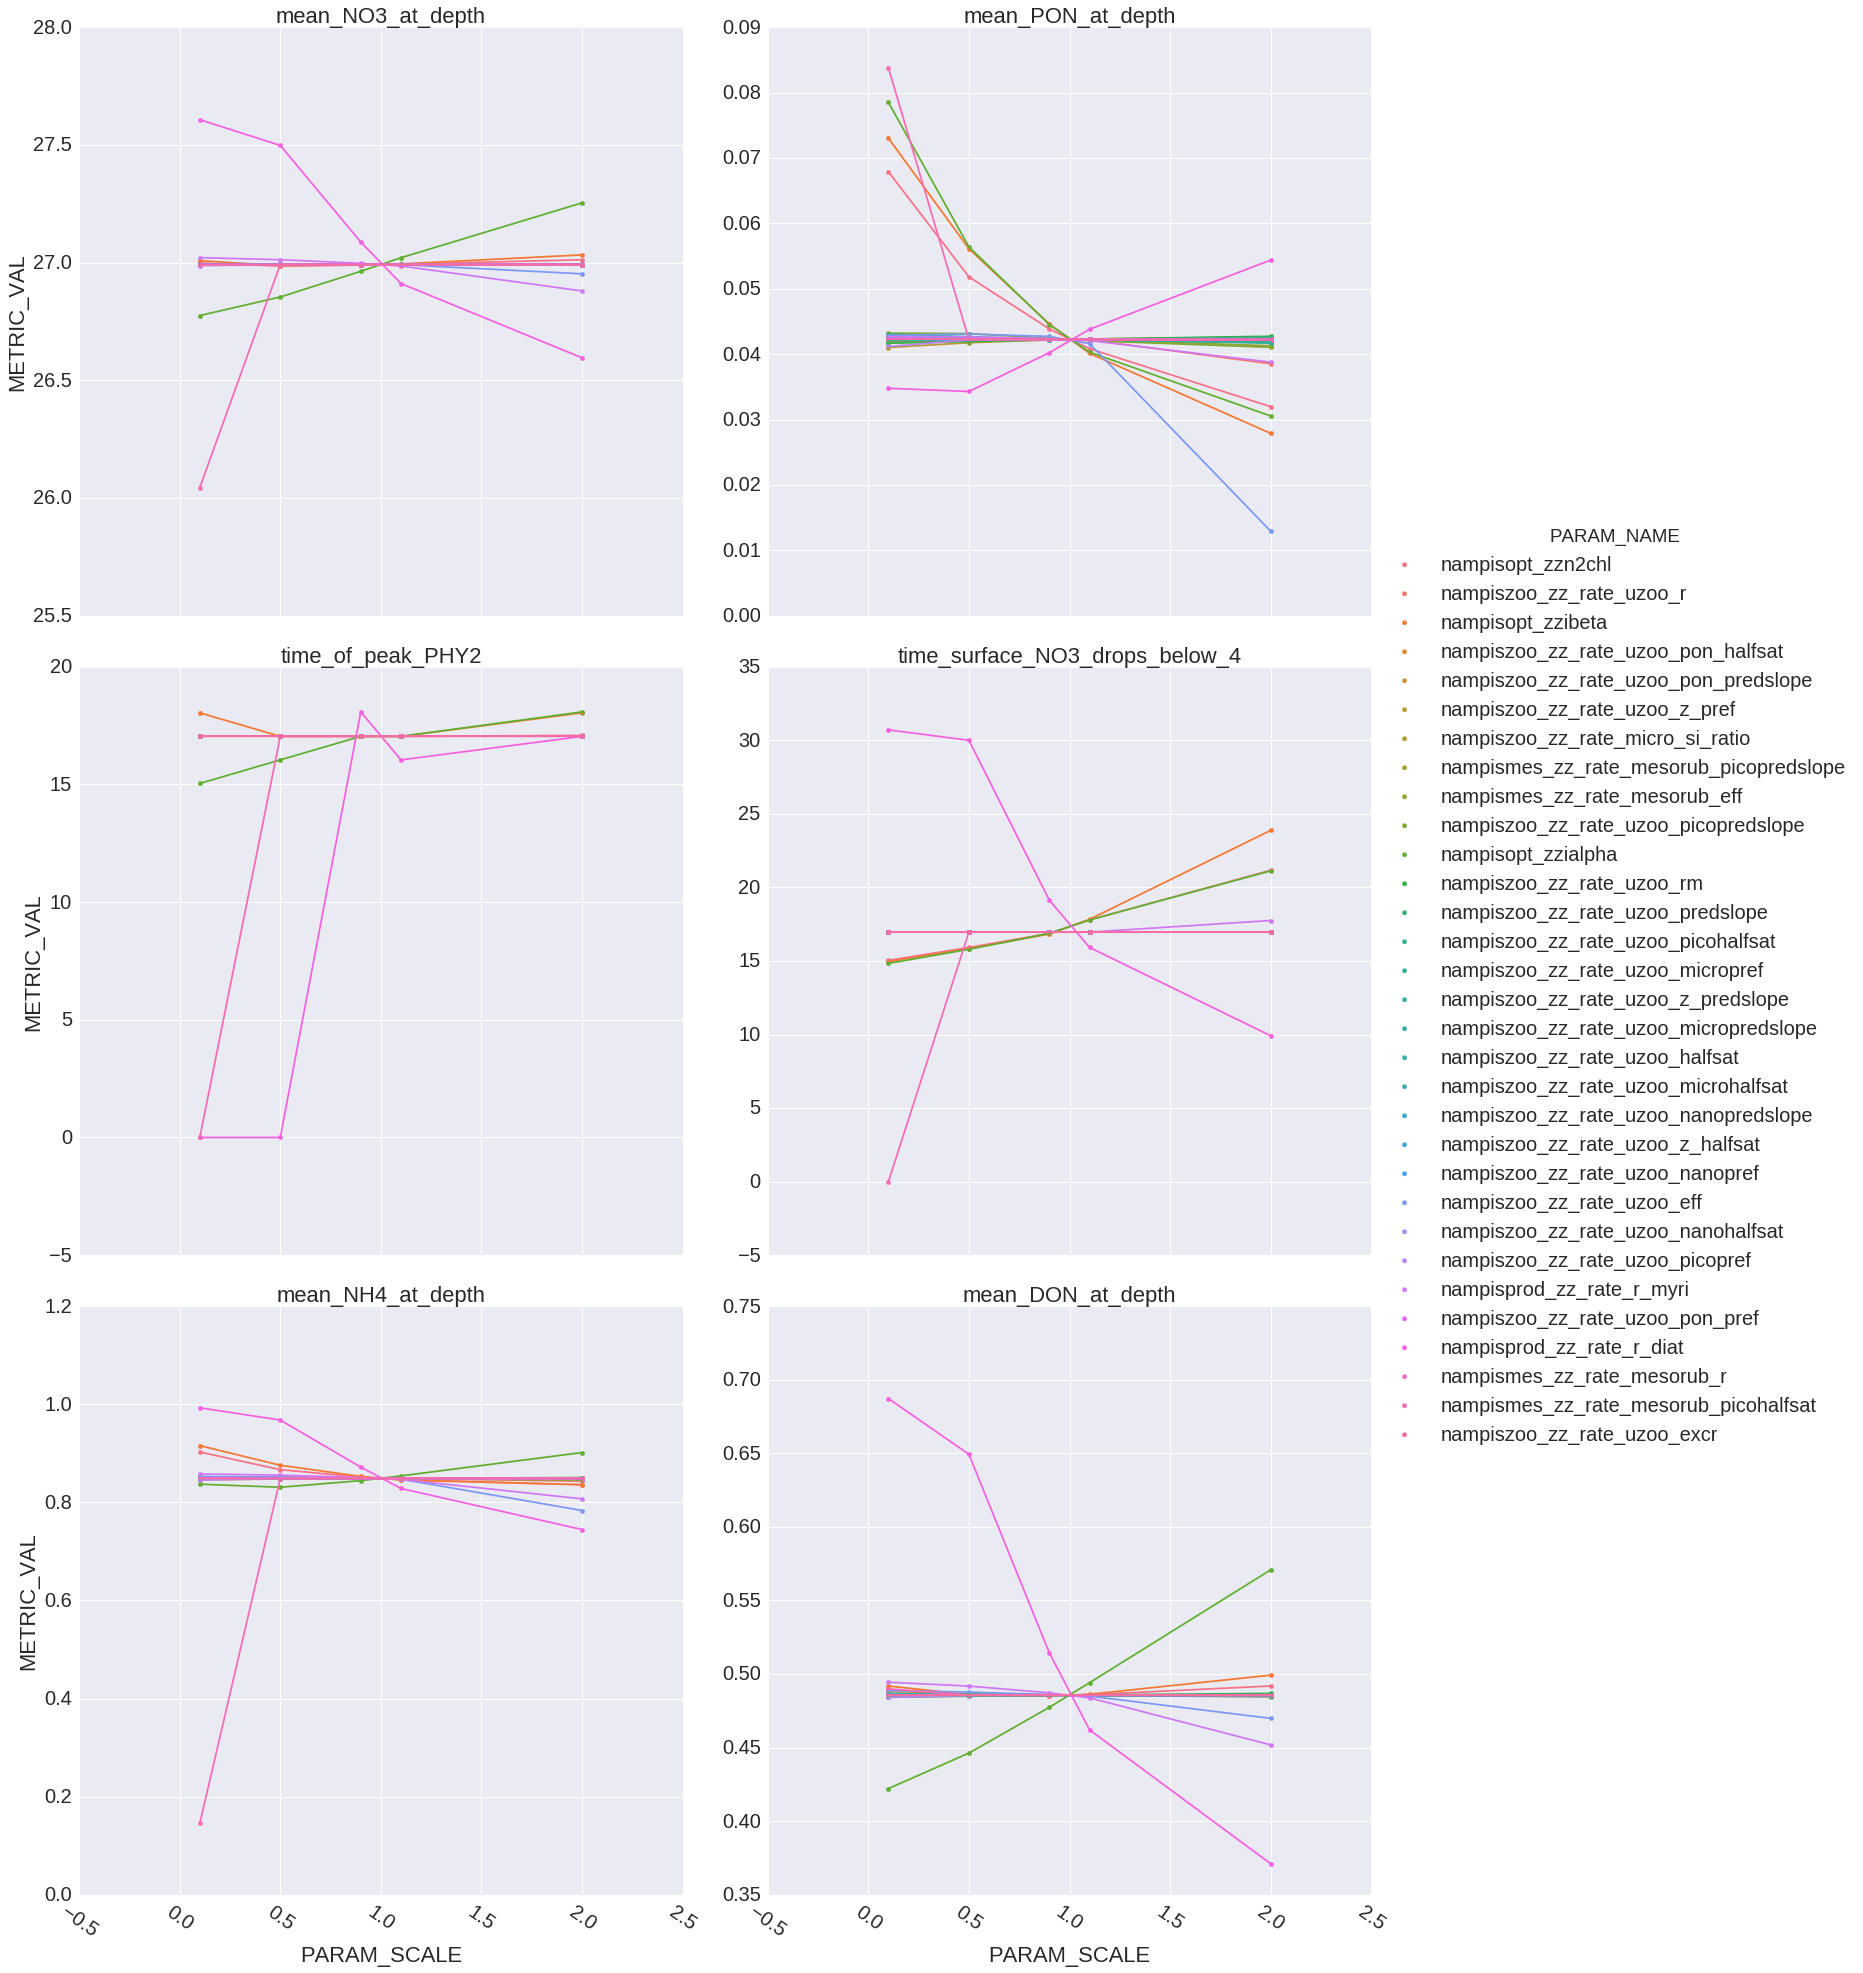

In [31]:
sns.set(font_scale = 2)
plt.rcParams['image.cmap'] = 'jet'

param_metrics = param_metrics.sort_values("PARAM_SCALE")

fg = sns.FacetGrid(data=param_metrics.query("PARAM_SCALE < 10"), col = "METRIC_NAME", hue = "PARAM_NAME",  sharey=False, col_wrap = 2, size = 10)
fg.map(plt.scatter, "PARAM_SCALE", "METRIC_VAL")
fg.map(plt.plot, "PARAM_SCALE", "METRIC_VAL").add_legend()
fg.set_xticklabels(rotation=-35)
plt.subplots_adjust(top=0.9)
#fg.set(xlim=(0, max(param_vals)))
fg.set_titles("{col_name}")

In [32]:
wide_format_metrics = pd.pivot_table(param_metrics, values='METRIC_VAL', index=['PARAM_NAME', 'METRIC_NAME'], columns=['PARAM_SCALE'])
wide_format_metrics.reset_index(inplace=True)
wide_format_metrics["SLOPE"] = (wide_format_metrics[1.1] - wide_format_metrics[0.9])/0.2
wide_format_metrics

PARAM_SCALE,PARAM_NAME,METRIC_NAME,0.1,0.5,0.9,1.1,2.0,10.0,SLOPE
0,nampismes_zz_rate_mesorub_eff,mean_DON_at_depth,0.485743,0.485680,0.485607,0.485563,0.485437,0.482575,-2.180056e-04
1,nampismes_zz_rate_mesorub_eff,mean_NH4_at_depth,0.849230,0.849075,0.848877,0.848754,0.847860,0.837153,-6.143289e-04
2,nampismes_zz_rate_mesorub_eff,mean_NO3_at_depth,26.991773,26.991813,26.991842,26.991832,26.991767,26.986538,-5.148585e-05
3,nampismes_zz_rate_mesorub_eff,mean_PON_at_depth,0.042427,0.042380,0.042285,0.042220,0.041290,0.034660,-3.264208e-04
4,nampismes_zz_rate_mesorub_eff,time_of_peak_PHY2,17.041667,17.041667,17.041667,17.041667,17.041667,17.041667,0.000000e+00
5,nampismes_zz_rate_mesorub_eff,time_surface_NO3_drops_below_4,16.958333,16.958333,16.958333,16.958333,16.958333,16.958333,0.000000e+00
6,nampismes_zz_rate_mesorub_picohalfsat,mean_DON_at_depth,0.489896,0.485692,0.485594,0.485579,0.485561,0.485589,-7.599946e-05
7,nampismes_zz_rate_mesorub_picohalfsat,mean_NH4_at_depth,0.145453,0.848924,0.848823,0.848814,0.848818,0.848898,-4.638840e-05
8,nampismes_zz_rate_mesorub_picohalfsat,mean_NO3_at_depth,26.044460,26.992165,26.991885,26.991798,26.991583,26.991454,-4.350338e-04
9,nampismes_zz_rate_mesorub_picohalfsat,mean_PON_at_depth,0.083788,0.042228,0.042249,0.042258,0.042279,0.042317,4.417585e-05


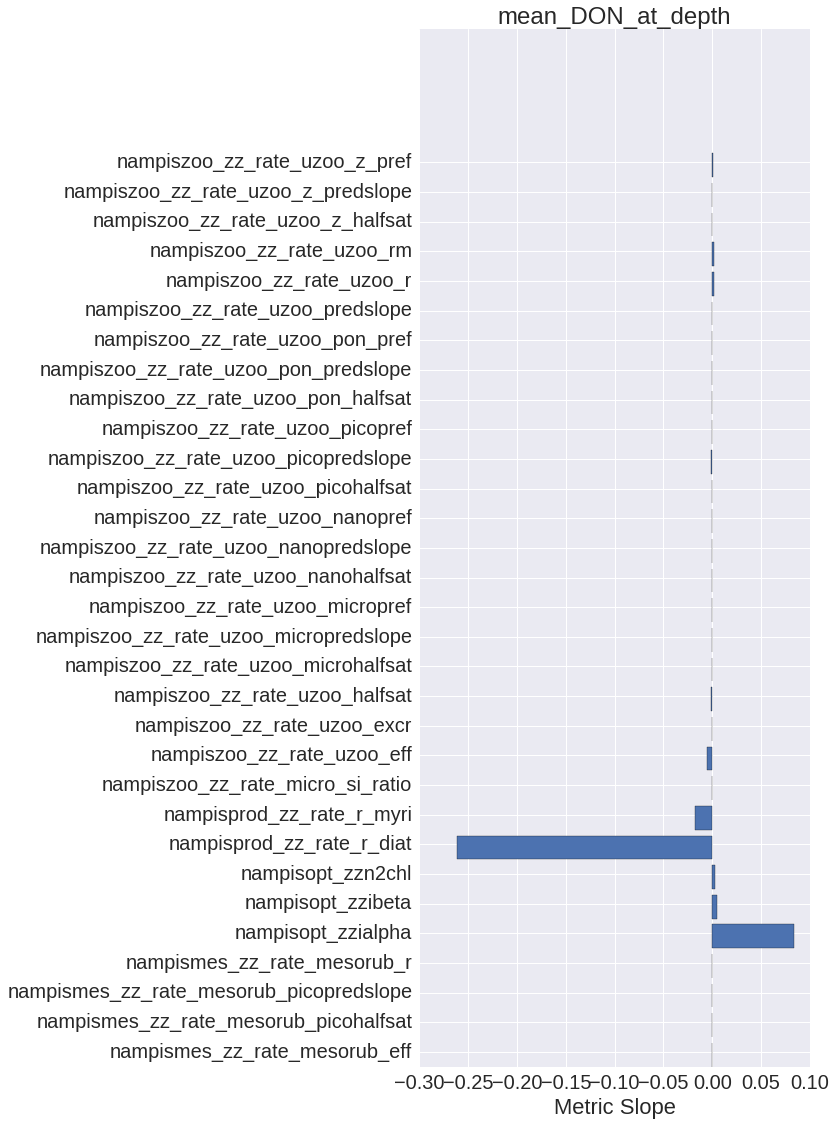

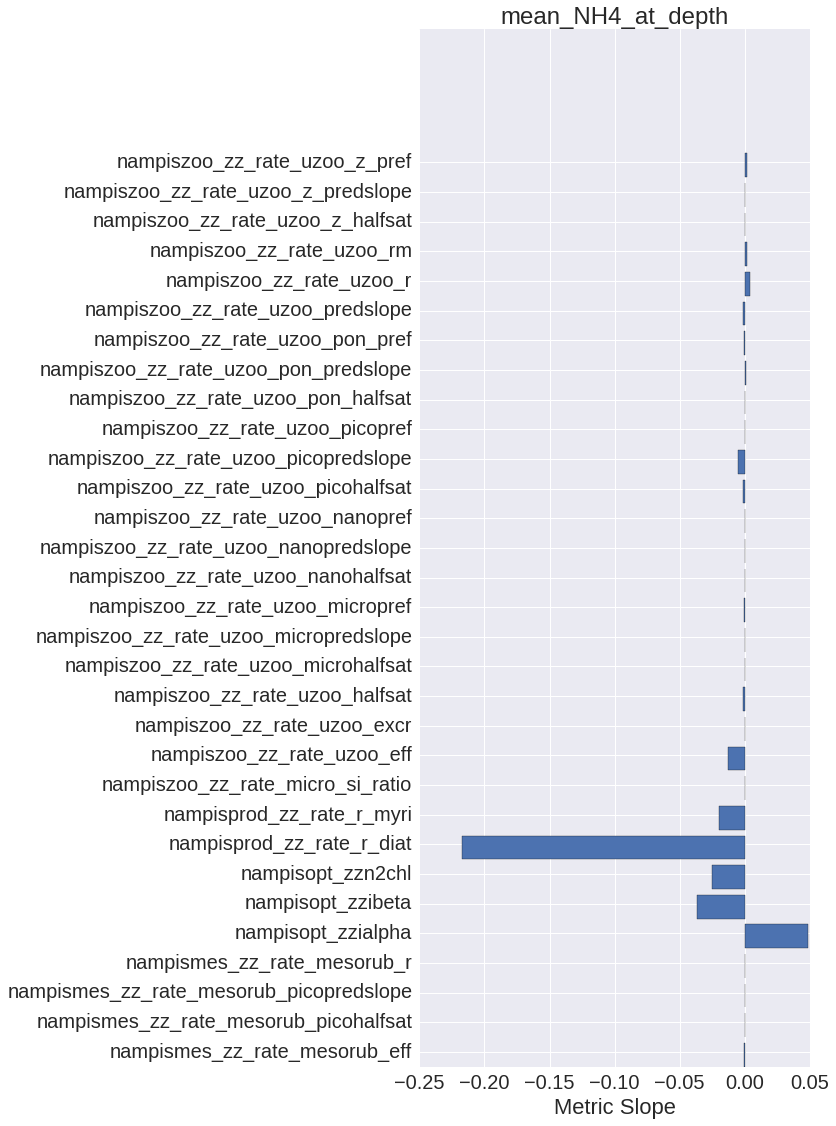

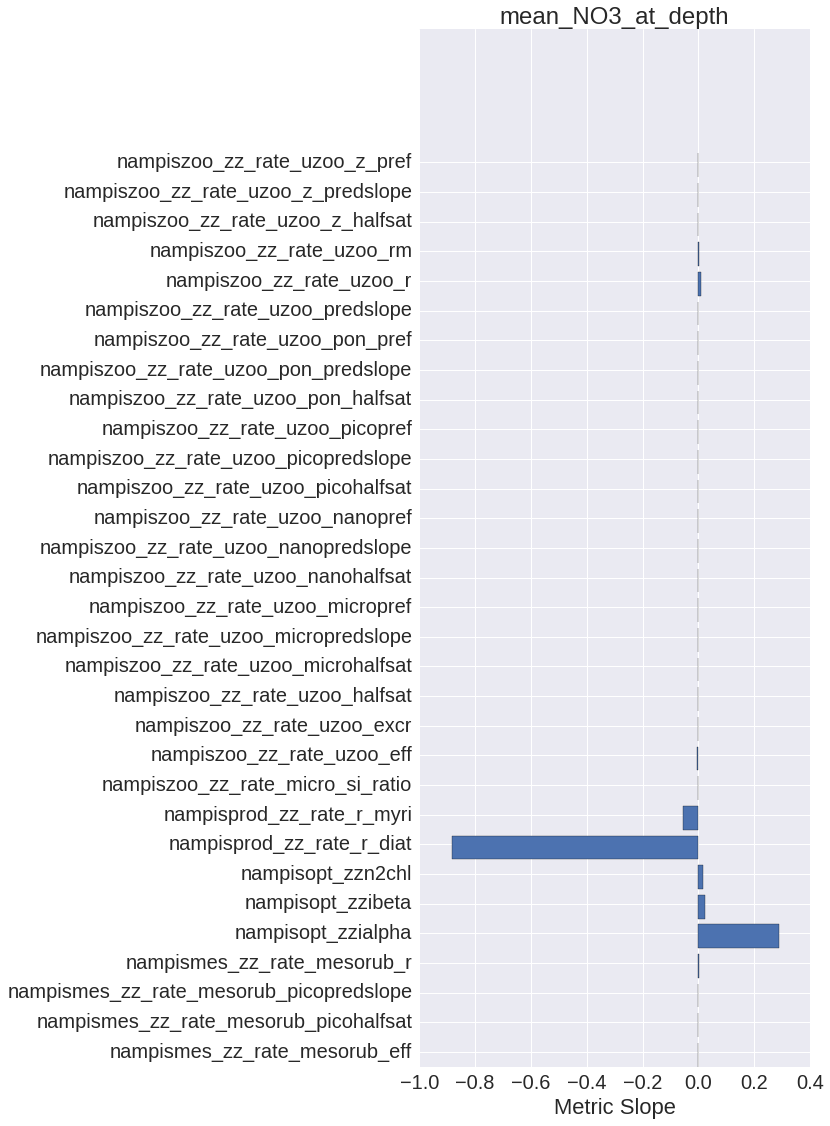

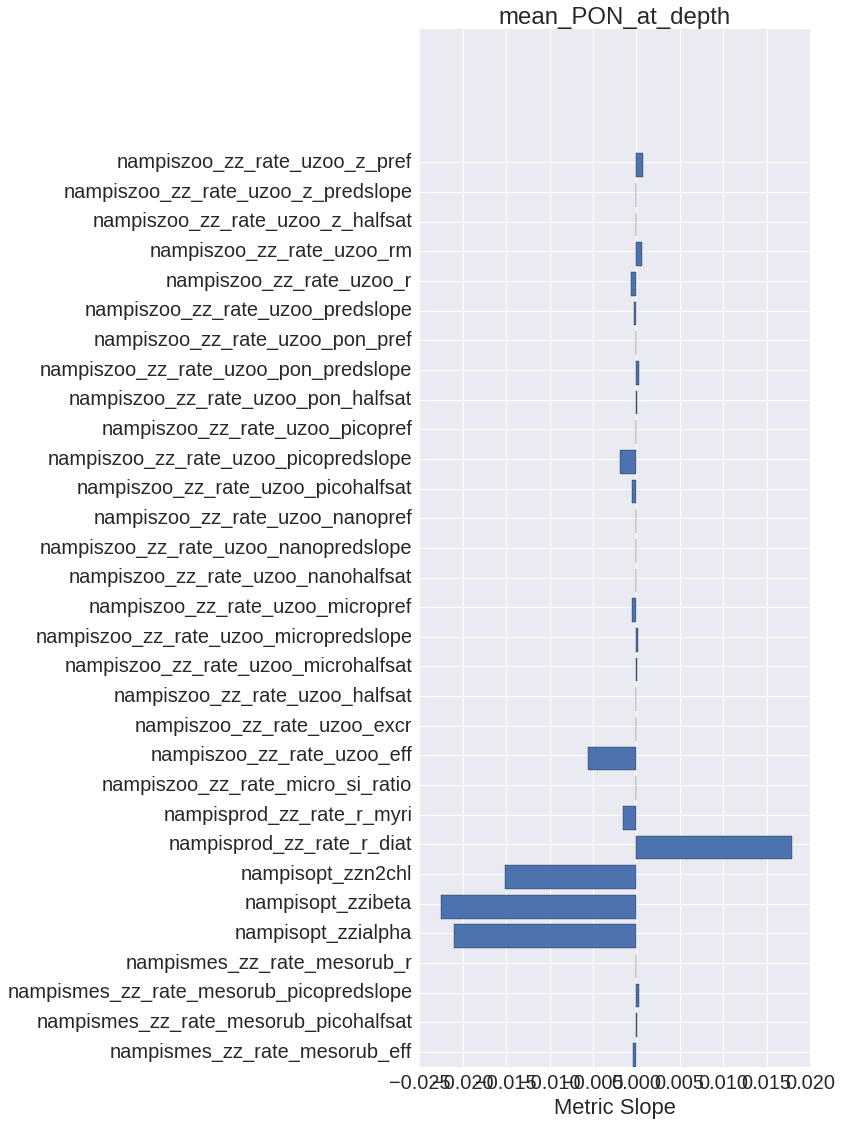

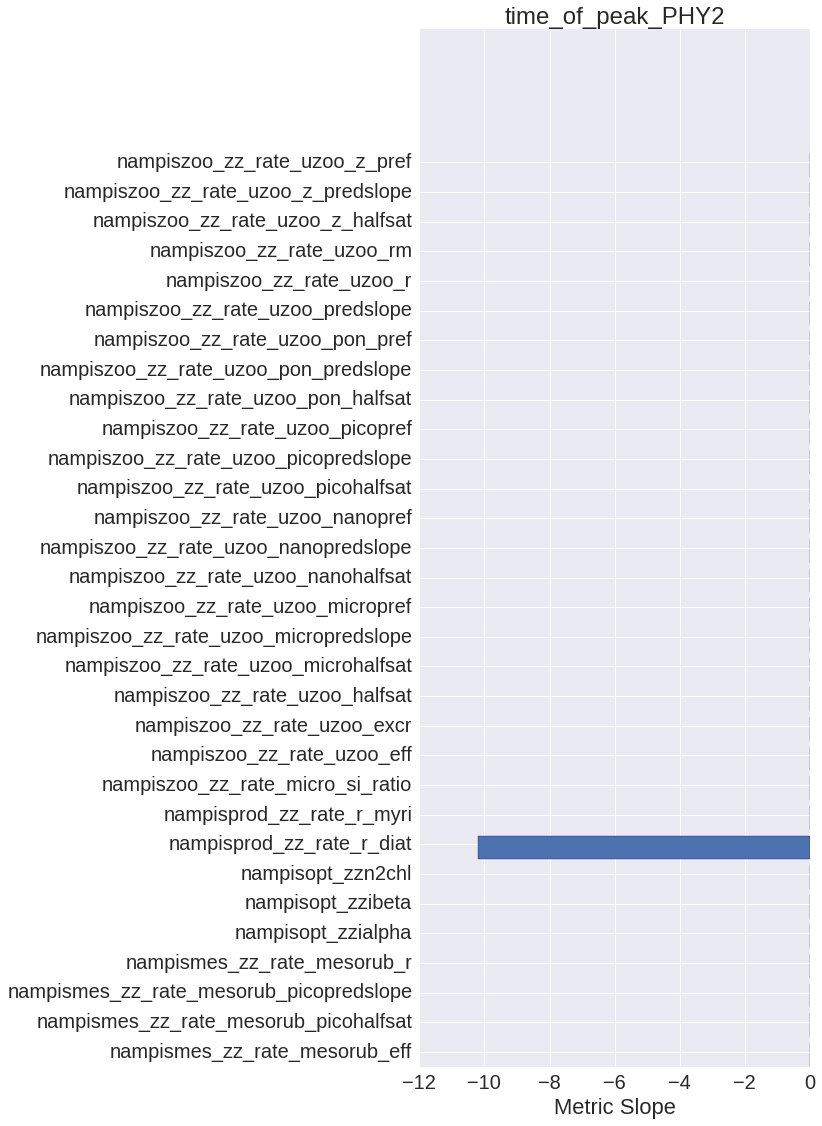

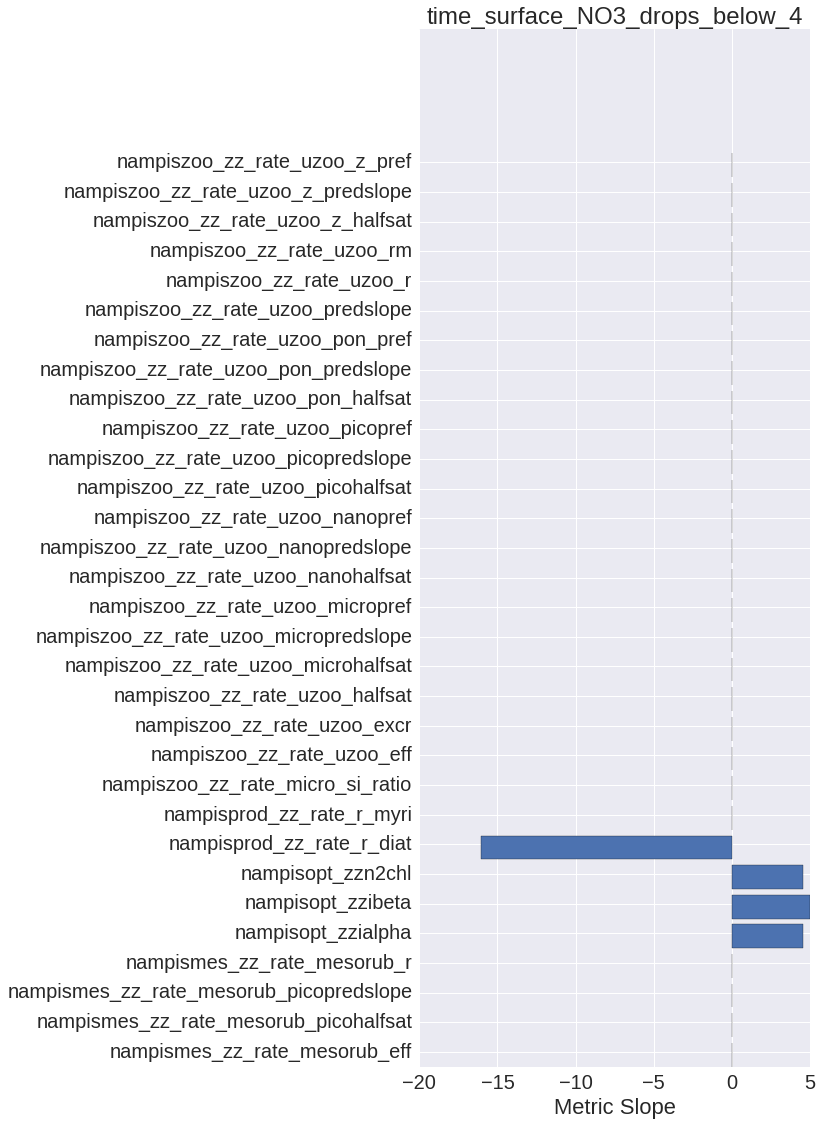

In [33]:
for metric_name in np.unique(wide_format_metrics["METRIC_NAME"]):
    x = wide_format_metrics.query("METRIC_NAME == @metric_name")

    fix, ax = plt.subplots(figsize = (7,0.6*len(x["SLOPE"])))
    ax.barh(np.arange(len(x["SLOPE"])) , (x["SLOPE"]))
    plt.yticks(np.arange(len(x["SLOPE"])) + 0.5, x["PARAM_NAME"])
    plt.title(metric_name)
    plt.xlabel("Metric Slope")
